# $\textbf{PROGRAMMING ASSIGNMENT}$
# $\textbf{Lecture 4: Bernoulli Mixture Modelling Assignment}$

1. Read the Bernoulli Mixture Model Derivation.
2. Read about Stochastic Expectation-Maximization (EM) Algorithm: https://www.sciencedirect.com/science/article/pii/S0167947320302504.
3. From the given code, modify the EM algorithm to become a Stochastic EM Algorithm.
4. Use the data from the paper: https://www.sciencedirect.com/science/article/abs/pii/S0031320322001753
5. Perform categorical clustering using the Bernoulli Mixture Model with Stochastic EM Algorithm.
6. Compare its performance with K-Modes Algorithm using Folkes-Mallows Index, Adjusted Rand Index, and Normalized Mutual Information Score.
7. Compare and contrast the performances, and explain what is happening (i.e. why is FMI always higher than ARI and NMI? Why is ARI and NMI low compared to FMI? etc.)
8. Write the report in Latex, push to your github with the codes.

---

Data: [Soybean (Large)](https://archive.ics.uci.edu/dataset/90/soybean+large)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from kmodes.kmodes import KModes
from scipy.special import logsumexp
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import fowlkes_mallows_score, adjusted_rand_score, normalized_mutual_info_score

### $\textbf{Exploratory Data Analysis}$

In [2]:
soybean_large = fetch_ucirepo(id=90)
soybean_large.variables

,name,role,type,demographic,description,units,missing_values
0,class,Target,Categorical,None,"diaporthe-stem-canker, charcoal-rot, rhizocton...",None,no
1,date,Feature,Categorical,None,"april,may,june,july,august,september,october,?",None,yes
2,plant-stand,Feature,Categorical,None,"normal,lt-normal,?",None,yes
3,precip,Feature,Categorical,None,"lt-norm,norm,gt-norm,?",None,yes
4,temp,Feature,Categorical,None,"lt-norm,norm,gt-norm,?",None,yes
5,hail,Feature,Categorical,None,"yes,no,?",None,yes
6,crop-hist,Feature,Categorical,None,"diff-lst-year,same-lst-yr,same-lst-two-yrs,sam...",None,yes
7,area-damaged,Feature,Categorical,None,"scattered,low-areas,upper-areas,whole-field,?",None,yes
8,severity,Feature,Categorical,None,"minor,pot-severe,severe,?",None,yes
9,seed-tmt,Feature,Categorical,None,"none,fungicide,other,?",None,yes


In [3]:
df = pd.merge(soybean_large.data.features, soybean_large.data.targets, left_index=True, right_index=True)
df.head()

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,...,sclerotia,fruit-pods,fruit-spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots,class
0,6.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,diaporthe-stem-canker
1,4.0,0.0,2.0,1.0,0.0,2.0,0.0,2.0,1.0,1.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,diaporthe-stem-canker
2,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,1.0,2.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,diaporthe-stem-canker
3,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,diaporthe-stem-canker
4,6.0,0.0,2.0,1.0,0.0,2.0,0.0,1.0,0.0,2.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,diaporthe-stem-canker


In [4]:
df.describe()

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,...,int-discolor,sclerotia,fruit-pods,fruit-spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots
count,306.000000,299.000000,296.000000,300.000000,266.000000,306.000000,306.000000,266.000000,266.000000,271.000000,...,296.000000,296.000000,282.000000,272.000000,278.000000,278.000000,272.000000,278.000000,272.000000,300.000000
mean,3.529412,0.464883,1.577703,1.130000,0.206767,1.816993,1.633987,0.778195,0.548872,1.014760,...,0.135135,0.033784,0.549645,1.084559,0.183453,0.111511,0.102941,0.097122,0.058824,0.156667
std,1.712285,0.499601,0.713580,0.622676,0.405750,0.994661,1.078868,0.620145,0.632052,0.798009,...,0.430193,0.180978,0.965241,1.575944,0.387736,0.315331,0.304442,0.296658,0.235728,0.423541
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,2.000000,1.000000,0.000000,2.000000,2.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,2.000000,2.000000,0.000000,3.000000,3.000000,1.000000,1.000000,2.000000,...,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,1.000000,2.000000,2.000000,1.000000,3.000000,3.000000,2.000000,2.000000,2.000000,...,2.000000,1.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [5]:
df.isna().sum()

date                1
plant-stand         8
precip             11
temp                7
hail               41
crop-hist           1
area-damaged        1
severity           41
seed-tmt           41
germination        36
plant-growth        1
leaves              0
leafspots-halo     25
leafspots-marg     25
leafspot-size      25
leaf-shread        26
leaf-malf          25
leaf-mild          30
stem                1
lodging            41
stem-cankers       11
canker-lesion      11
fruiting-bodies    35
external-decay     11
mycelium           11
int-discolor       11
sclerotia          11
fruit-pods         25
fruit-spots        35
seed               29
mold-growth        29
seed-discolor      35
seed-size          29
shriveling         35
roots               7
class               0
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isna().sum()

date               0
plant-stand        0
precip             0
temp               0
hail               0
crop-hist          0
area-damaged       0
severity           0
seed-tmt           0
germination        0
plant-growth       0
leaves             0
leafspots-halo     0
leafspots-marg     0
leafspot-size      0
leaf-shread        0
leaf-malf          0
leaf-mild          0
stem               0
lodging            0
stem-cankers       0
canker-lesion      0
fruiting-bodies    0
external-decay     0
mycelium           0
int-discolor       0
sclerotia          0
fruit-pods         0
fruit-spots        0
seed               0
mold-growth        0
seed-discolor      0
seed-size          0
shriveling         0
roots              0
class              0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266 entries, 0 to 289
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             266 non-null    float64
 1   plant-stand      266 non-null    float64
 2   precip           266 non-null    float64
 3   temp             266 non-null    float64
 4   hail             266 non-null    float64
 5   crop-hist        266 non-null    float64
 6   area-damaged     266 non-null    float64
 7   severity         266 non-null    float64
 8   seed-tmt         266 non-null    float64
 9   germination      266 non-null    float64
 10  plant-growth     266 non-null    float64
 11  leaves           266 non-null    int64  
 12  leafspots-halo   266 non-null    float64
 13  leafspots-marg   266 non-null    float64
 14  leafspot-size    266 non-null    float64
 15  leaf-shread      266 non-null    float64
 16  leaf-malf        266 non-null    float64
 17  leaf-mild        266 

### $\textbf{Stochastic Bernoulli Mixture}$

In [8]:
class StochasticBernoulliMixture:
    def __init__(self, n_components, max_iter, batch_size, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.random_state = random_state
        self.rng = np.random.default_rng(self.random_state) if self.random_state else np.random.default_rng()
        self.old_mu = None
        self.old_pi = None
        self.old_gamma = None

    def fit(self, x_binary):
        self.x = x_binary
        self.init_params()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.old_logL = self.get_log_likelihood(log_bernoullis)
        for step in range(self.max_iter):
            if step > 0:
                self.old_logL = self.logL

            for _ in range(self.batch_size):
                batch_indices = self.rng.choice(len(self.x), size=self.batch_size, replace=False)
                x_batch = self.x.iloc[batch_indices]
                log_bernoullis_batch = self.get_log_bernoullis(x_batch)
                self.gamma = self.get_responsibilities(log_bernoullis_batch)
                self.get_Neff()
                self.get_mu(x_batch)
                self.get_pi()

            log_bernoullis = self.get_log_bernoullis(self.x)
            self.logL = self.get_log_likelihood(log_bernoullis)
            if np.isnan(self.logL):
                self.reset_params()
                print(self.logL)
                break

    def reset_params(self):
        if self.old_mu is not None:
            self.mu = self.old_mu.copy()
        if self.old_pi is not None:
            self.pi = self.old_pi.copy()
        if self.old_gamma is not None:
            self.gamma = self.old_gamma.copy()
        self.get_Neff()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.logL = self.get_log_likelihood(log_bernoullis)

    def remember_params(self):
        self.old_mu = self.mu.copy()
        self.old_pi = self.pi.copy()
        self.old_gamma = self.gamma.copy()

    def init_params(self):
        self.n_samples = self.x.shape[0]
        self.n_features = self.x.shape[1]
        self.pi = 1/self.n_components * np.ones(self.n_components)
        self.mu = self.rng.uniform(low=0.25, high=0.75, size=(self.n_components, self.n_features))
        self.normalize_mu()

    def normalize_mu(self):
        sum_over_features = np.sum(self.mu, axis=1)
        for k in range(self.n_components):
            self.mu[k,:] /= sum_over_features[k]

    def get_responsibilities(self, log_bernoullis):
        gamma = np.zeros(shape=(log_bernoullis.shape[0], self.n_components))
        Z =  logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
        for k in range(self.n_components):
            gamma[:, k] = np.exp(np.log(self.pi[k]) + log_bernoullis[:,k] - Z)
        return gamma

    def get_log_bernoullis(self, x):
        log_bernoullis = self.get_save_single(x, self.mu)
        log_bernoullis += self.get_save_single(1-x, 1-self.mu)
        return log_bernoullis

    def get_save_single(self, x, mu):
        mu_place = np.where(np.max(mu, axis=0) <= 1e-15, 1e-15, mu)
        return np.tensordot(x, np.log(mu_place), (1,1))

    def get_Neff(self):
        self.Neff = np.sum(self.gamma, axis=0)

    def get_mu(self, x_batch):
        self.mu = np.einsum('ik,ij -> kj', self.gamma, x_batch) / self.Neff[:,None]


    def get_pi(self):
        self.pi = self.Neff / self.n_samples

    def predict(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        gamma = self.get_responsibilities(log_bernoullis)
        return np.argmax(gamma, axis=1)

    def get_sample_log_likelihood(self, log_bernoullis):
        return logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)

    def get_log_likelihood(self, log_bernoullis):
        return np.mean(self.get_sample_log_likelihood(log_bernoullis))

    def score(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_log_likelihood(log_bernoullis)

    def score_samples(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_sample_log_likelihood(log_bernoullis)

### $\textbf{KModes vs Stochastic Bernoulli Mixture}$

In [9]:
X = df.drop(columns=['class'])
y = df['class']

encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(X)
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(X.columns))

encoded_df.head()

,date_0.0,date_1.0,date_2.0,date_3.0,date_4.0,date_5.0,date_6.0,plant-stand_0.0,plant-stand_1.0,precip_0.0,...,mold-growth_1.0,seed-discolor_0.0,seed-discolor_1.0,seed-size_0.0,seed-size_1.0,shriveling_0.0,shriveling_1.0,roots_0.0,roots_1.0,roots_2.0
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [10]:
km = KModes(n_clusters=5, init='Huang', n_init=5)
df["km_clusters"] = km.fit_predict(encoded_df)
df["km_clusters"]

0      4
1      4
2      4
3      4
4      4
      ..
285    1
286    3
287    3
288    3
289    3
Name: km_clusters, Length: 266, dtype: uint16

In [11]:
stochastic_bernoulli = StochasticBernoulliMixture(n_components=5, max_iter=500, batch_size=5)

stochastic_bernoulli.fit(encoded_df)
df["sbm_clusters"] = stochastic_bernoulli.predict(encoded_df)
df["sbm_clusters"]

nan


C:\Users\seals\AppData\Local\Temp\ipykernel_21484\3685587145.py:79: RuntimeWarning: divide by zero encountered in log
  return np.tensordot(x, np.log(mu_place), (1,1))


0      0
1      0
2      0
3      0
4      0
      ..
285    0
286    0
287    0
288    0
289    0
Name: sbm_clusters, Length: 266, dtype: int64

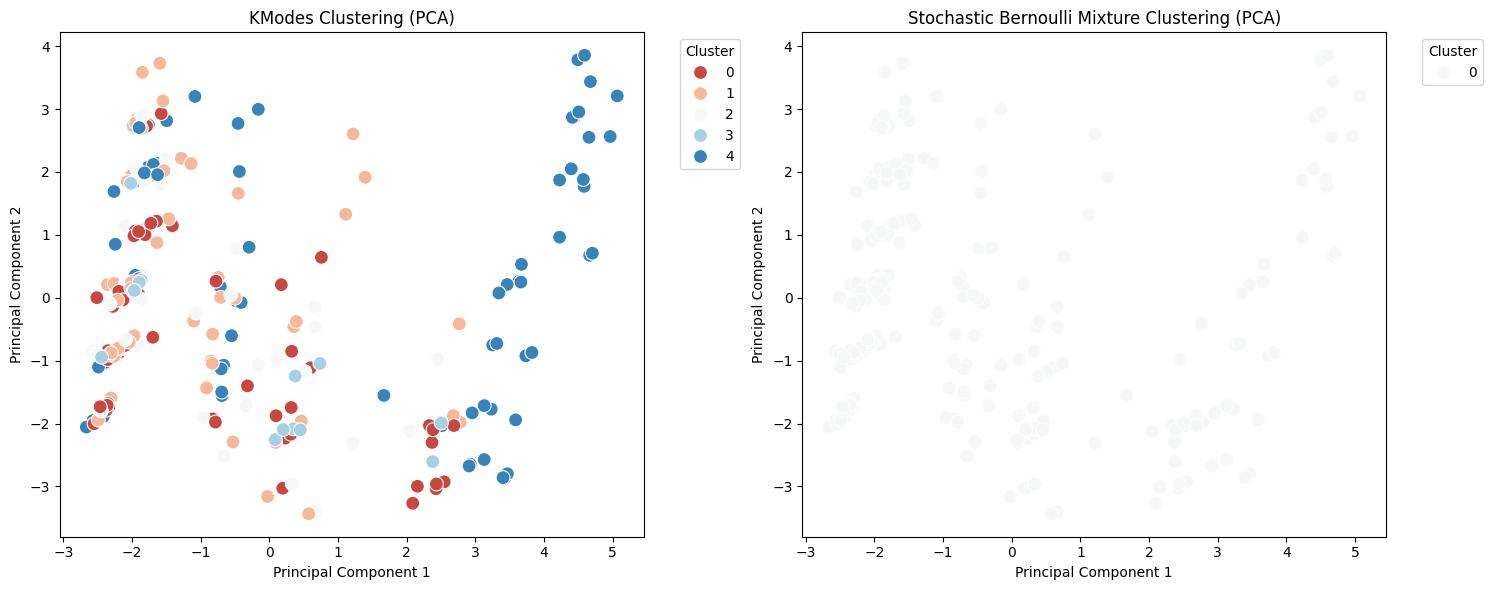

In [12]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

pca_df['km_cluster'] = df['km_clusters'].astype('category')
pca_df['sbm_cluster'] = df['sbm_clusters'].astype('category')

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='km_cluster', s=100, palette='RdBu')
plt.title('KModes Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(1, 2, 2)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='sbm_cluster', s=100, palette='RdBu')
plt.title('Stochastic Bernoulli Mixture Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [13]:
fmi_km = fowlkes_mallows_score(y, df['km_clusters'])
ari_km = adjusted_rand_score(y, df['km_clusters'])
nmi_km = normalized_mutual_info_score(y, df['km_clusters'])

fmi_hc = fowlkes_mallows_score(y, df['sbm_clusters'])
ari_hc = adjusted_rand_score(y, df['sbm_clusters'])
nmi_hc = normalized_mutual_info_score(y, df['sbm_clusters'])

results = {
    'Method': ['Kmodes', 'Stochastic Bernoulli Mixture'],
    'FMI': [fmi_km, fmi_hc],
    'ARI': [ari_km, ari_hc],
    'NMI': [nmi_km, nmi_hc]
}

df_results = pd.DataFrame(results)
df_results

,Method,FMI,ARI,NMI
0,Kmodes,0.306483,0.172783,0.39754
1,Stochastic Bernoulli Mixture,0.303430,0.000000,0.00000


### $\textbf{Report}$

Evaluating the performance metrics—FMI (Folkes-Mallows Index), ARI (Adjusted Rand Index), and NMI (Normalized Mutual Information)—for the clustering methods Kmodes and Stochastic Bernoulli Mixture reveals their effectiveness in capturing clustering quality.

1. **FMI (Fowlkes-Mallows Index):**
   - Measures similarity between clusters using pairwise precision and recall.
   - Higher FMI for the Stochastic Bernoulli Mixture method indicates better clustering similarity.

2. **ARI (Adjusted Rand Index):**
   - Measures similarity between clusterings, adjusted for chance.
   - Both methods show low ARI, with Stochastic Bernoulli Mixture having zero, indicating poor clustering agreement.

3. **NMI (Normalized Mutual Information):**
   - Measures mutual dependence between clusterings, adjusted for chance.
   - Low NMI values for both methods, with Stochastic Bernoulli Mixture reporting zero, indicating low mutual information.

In [14]:
df_results

,Method,FMI,ARI,NMI
0,Kmodes,0.306483,0.172783,0.39754
1,Stochastic Bernoulli Mixture,0.303430,0.000000,0.00000


- **FMI vs. ARI and NMI:** FMI is often higher than ARI and NMI because it focuses on pairwise precision and recall within clusters, while ARI and NMI evaluate overall clustering agreement, including chance agreements.

- **ARI and NMI discrepancies:** ARI and NMI may be low when clustering structures differ or clusters are poorly defined. The Stochastic Bernoulli Mixture method's low ARI and NMI suggest significant divergence from Kmodes' clustering assignments.

- **Zero ARI and NMI:** A zero score indicates that the clustering results are essentially random compared to the reference clustering, showing a failure to capture meaningful patterns.

While the Stochastic Bernoulli Mixture method shows better similarity within clusters (higher FMI), it diverges significantly from reference clustering, resulting in low ARI and NMI scores. Further refinement is needed to improve its clustering quality.